# Curso de Especialização em Ciência de Dados - FURG
## Artigo SBC - Modelo preditivo de situação fiscal de microempresas em Pernambuco a partir do ano 2000 com base nos dados abertos RFB utilizando e fatores macroeconômicos por município.

Modelo baseado nas aulas de Machine Learning I

In [1]:
# Importação das Bibliotecas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import scipy
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# 1. Observar o quadro geral

O contexto deste projeto é a partir dos dados abertos RFB analisar qual seria a situação cadastral de uma empresa de Pernambuco considerando a atividade, municipio, IDH, PIB e arrecadação fiscal do municipio e tempo de funcionamento do empreendimento. Como tempo de funcionamento consideramos data do inicio de atividade e data da situação cadastral da empresa.

## 1.1 Contextualizar o problema
Varios são os fatores que interferem no sucesso ou fracasso das empresas, podendo ser de ordem interna, externa, microeconomica  ou macroeconomica. Neste trabalho, vamos analisar como a partir de fatores macroeconomicos externos, a saber, PIB do municipio, IHD e agregados relativos ao IDH do municipio, arrecadação fiscal do municipio , juntamente com fatores microeconomicos de atividade, porte da empresa, natureza jurídica, data de abertura, o desempenho das empresas são afetados, a ponto de determinar sua situção fiscal conforme denominação utilizada pela RFB, nula, ativa, suspensa, inapta ou baixada.

Para analise inicial, elencamos o estado de Pernambuco e empresas segmentadas por municipio. A partir do modelo preditivo, queremos prever se uma empresa em determinada atividade tem maior ou menor probabilidade de sucesso, tempo de vida, ao ser instalada em determinado local.

Efetuaremos uma pesquisa do tipo exploratória e prescritiva de abordagem quantitativa a partir da aplicação do algoritmo KNN, utilizando atributos numericos para efetuar a categorização da situação fiscal da empresa em nula, ativa, suspensa, inapta, baixada.


## 1.2 Qual a saída esperada?

Nossa expectativa é prever a situação fiscal da empresa a partir dos dados de PORTE, IDH Municipio e agregados IDHM, PIB Municipio, Atividade, nartureza jurídica, data de abertura da empresa e porte.

Utilizaremos algoritmo de Classificação supervisionado K-Nearest Neighbors para prever a situação fiscal da empresa conforme abaixo:\
1 – NULA\
2 – ATIVA\
3 – SUSPENSA\
4 – INAPTA\
8 – BAIXADA\\

Para previsão do tempo da atividade utilizaremos o algoritimo não supervisionado regressão polinomial.

## 1.3 Enquadrar o problema

Para classificação da Situação Fiscal será utilizada tecnica de **aprendizado supervisionado** com exemplos de treinamento rotulados [1,2,3,4,8] por meio de distancia Euclidiana.


Para definição do tempo de vida da empresa utilizaremos algoritmo de **regressão polinomial**, uma vez deseja-se prever um valor numérico.

O modelo não possui retroalimentação continua, de sorte que não há necessidade de se ajustar a dados variáveis rapidamente. Como os dados são pequenos o suficiente para caber na memória, é possível usar a estratégia de **aprendizado em lote**.

## 1.4 Selecionar uma medida de desempenho

Para este problema será utilizada a medida Root Mean Square Error: 

\begin{align}
\text{RMSE}(\textbf{X}, h) = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left( h(\textbf{x}^{(i)}) - y^{(i)} \right) ^2 }
\end{align}

Para comparação, também será utilizada a medida Mean Absolute Error:

\begin{align}
\text{MAE}(\textbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(\textbf{x}^{(i)}) - y^{(i)} \right|
\end{align}

Quanto mais alto o expoente aplicado à diferente, mais o erro se concentra em grandes valores, negligenciando pequenos. É por isso que a RMSE é mais sensível a _outliers_ do que a MAE.

Porém, quando _outliers_ são mais raros (como em uma curva em forma de sino), a RMSE executa muito bem e geralmente é a medida preferida.

## 1.5 Verifique as premissas

Por exemplo, é preciso verificar se os preços previstos estão no formato adequado. No caso, devem ser valores numéricos, em dólares, e não categorias discretas.

# 2. Obter os dados

Para este projeto, utilizamos os dados abaixo:

Dados Abertos CNPJ EMPRESA\
Dados Abertos CNPJ ESTABELECIMENTO\
Informações sobre o Simples Nacional/MEI\
Tabela de atributo CNAE\
Tabela de motivo da situação cadastral\
Tabela de atributo Município\
Tabela de atributo Natureza Jurídica\
Tabela de atributo País\
Tabela de atributo qualificação dos sócios\
Arrecadação MUNICIPIOS (2019)\
IDH Brasil por Municipio (2010)\
PIB por Municipio (2019)\

## 2.1 Examinar os dados

In [ ]:
# cada linha representa uma empresa
import os
#os.chdir('D:\#PROJETOS\FURG\ECD-CIENCIA DE DADOS\#TCC-FURG\BASE-RFB-12-03-2022\TRATADA')
os.chdir("/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL")
empresaspe = pd.read_csv('BaseFinalSel.csv', sep=",", encoding='UTF-8')

In [ ]:
empresaspe.sample(5)

,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,IBGE,CNPJ_BASICO,NATJU,CAP_SOCIAL,PORTE,CNPJ_ORDEM,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_y,População 2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA
21347,2601102,223,602,785,467,595,260110,9713827,2135,0,5,1.000,1,8,20081231,71,19660804,4755501,1048186.103,77302,42107779.300,2008,1966,42
649718,2611606,53,772,825,698,798,261160,17085710,2062,10000,5,1.000,1,4,20181025,63,20121030,4617600,54691223.455,1537704,12556942916.660,2018,2012,6
516034,2611606,53,772,825,698,798,261160,14201471,2135,5000,1,1.000,1,8,20180201,67,20110829,1412602,54691223.455,1537704,12556942916.660,2018,2011,7
279028,2609600,90,735,836,675,704,260960,7536236,2135,0,1,1.000,1,8,20211117,1,20050719,4713002,5774906.513,377779,645825330.450,2021,2005,16
332086,2610301,288,537,703,418,528,261030,4054428,2135,0,1,1.000,1,4,20190326,63,20000906,4712100,219513.107,11001,7452089.740,2019,2000,19


In [ ]:
# visão geral
empresaspe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804032 entries, 0 to 804031
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IBGE7             804032 non-null  int64  
 1   Posição IDHM      804032 non-null  int64  
 2   IDHM              804032 non-null  int64  
 3   IDHM Renda        804032 non-null  int64  
 4   IDHM Educação     804032 non-null  int64  
 5   IDHM Longevidade  804032 non-null  int64  
 6   IBGE              804032 non-null  int64  
 7   CNPJ_BASICO       804032 non-null  int64  
 8   NATJU             804032 non-null  int64  
 9   CAP_SOCIAL        804032 non-null  int64  
 10  PORTE             804032 non-null  int64  
 11  CNPJ_ORDEM        804032 non-null  float64
 12  IDE_MAT_FIL       804032 non-null  int64  
 13  SIT_CADASTRAL     804032 non-null  int64  
 14  DATA_SIT_CADAS    804032 non-null  int64  
 15  MOT_SIT_CADAS     804032 non-null  int64  
 16  DATA_INI_ATV      80

In [ ]:
empresaspe = empresaspe.rename(columns={'PIB_y': 'PIB_MUNICIPIO','População 2010':'POP_2010'})

In [ ]:
# configurando variáveis do ambiente
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
empresaspe.describe()

,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,IBGE,CNPJ_BASICO,NATJU,CAP_SOCIAL,PORTE,CNPJ_ORDEM,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_MUNICIPIO,POP_2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA
count,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000,804032.000
mean,2609159.155,119.888,687.903,749.816,606.541,689.168,260915.440,19058599.452,2224.715,-3027682.497,2.337,6.437,1.078,5.783,20065222.428,25.624,20052385.502,5501697.513,23617677.469,701075.644,5124749364.563,2006.454,2005.172,1.283
std,3736.988,67.188,128.873,196.544,131.191,131.246,373.647,14690249.857,427.076,132174628.243,1.835,125.512,0.268,2.649,1231648.472,31.940,124819.585,2031173.219,24904276.571,674599.619,5952516269.042,123.161,12.483,123.201
min,2600054.000,37.000,6.000,8.000,42.000,53.000,260005.000,633.000,2038.000,-2147483648.000,1.000,1.000,1.000,1.000,0.000,0.000,19010101.000,111301.000,37869.808,2630.000,837467.860,0.000,1901.000,-2008.000
25%,2606200.000,53.000,661.000,785.000,565.000,632.000,260620.000,8649329.250,2062.000,0.000,1.000,1.000,1.000,2.000,20081231.000,1.000,19960911.000,4712100.000,1591320.358,79232.000,98688412.470,2008.000,1996.000,1.000
50%,2611101.000,93.000,732.000,806.000,675.000,695.000,261110.000,14644522.000,2135.000,1000.000,1.000,1.000,1.000,8.000,20170814.000,1.000,20091029.000,4781400.000,7610822.130,314912.000,645825330.450,2017.000,2009.000,6.000
75%,2611606.000,162.000,772.000,825.000,698.000,798.000,261160.000,27824522.250,2135.000,20000.000,5.000,1.000,1.000,8.000,20190328.000,63.000,20150729.000,6821801.000,54691223.455,1537704.000,12556942916.660,2019.000,2015.000,14.000
max,2616209.000,334.000,788.000,839.000,748.000,798.000,261620.000,98522246.000,8885.000,2136367451.000,5.000,9882.000,2.000,8.000,20220312.000,74.000,20220312.000,9900800.000,54691223.455,1537704.000,12556942916.660,2022.000,2022.000,119.000


In [ ]:
empresaspe.min()

IBGE7                  2600054.000
Posição IDHM                37.000
IDHM                         6.000
IDHM Renda                   8.000
IDHM Educação               42.000
IDHM Longevidade            53.000
IBGE                    260005.000
CNPJ_BASICO                633.000
NATJU                     2038.000
CAP_SOCIAL         -2147483648.000
PORTE                        1.000
CNPJ_ORDEM                   1.000
IDE_MAT_FIL                  1.000
SIT_CADASTRAL                1.000
DATA_SIT_CADAS               0.000
MOT_SIT_CADAS                0.000
DATA_INI_ATV          19010101.000
CNAE_FISCAL             111301.000
PIB_MUNICIPIO            37869.808
POP_2010                  2630.000
ARRECADACAO             837467.860
ANO_SIT_CADAS                0.000
ANO_INI_ATV               1901.000
TEMPO_VIDA               -2008.000
dtype: float64

In [ ]:
#Buscando valores negativos
empresaspe[empresaspe['CAP_SOCIAL'] < 0]['CAP_SOCIAL'].value_counts()

-2147483648    2437
Name: CAP_SOCIAL, dtype: int64

In [ ]:
#Buscando valores negativos
empresaspe[empresaspe['TEMPO_VIDA'] < 0]['TEMPO_VIDA'].value_counts()

-2004    1509
-2005     702
-2003     349
-2002     151
-2001     106
-2000      72
-1999      64
-1998      20
-1990      12
-2008       3
-1983       3
-2006       3
-1992       2
-1984       2
-1973       1
-1901       1
-1981       1
-8          1
-1982       1
-2          1
-1          1
-3          1
-1949       1
-1975       1
-1979       1
-1980       1
-2007       1
Name: TEMPO_VIDA, dtype: int64

In [ ]:
#Buscando a origem dos valores negativos
empresaspe[empresaspe['CAP_SOCIAL'] < 0]['ANO_INI_ATV'].head()
           

271     1994
5850    2011
5851    2009
5852    2015
5876    2010
Name: ANO_INI_ATV, dtype: int64

In [ ]:
empresaspe[empresaspe['CAP_SOCIAL'] < 0]['ANO_SIT_CADAS'].head()

271     2018
5850    2012
5851    2020
5852    2021
5876    2019
Name: ANO_SIT_CADAS, dtype: int64

In [ ]:
#Buscando valores negativos
empresaspe[empresaspe['TEMPO_VIDA'] < 0]['ANO_INI_ATV'].head()

28      2004
834     2005
1914    2004
2246    2005
3020    2000
Name: ANO_INI_ATV, dtype: int64

In [ ]:
#Buscando valores negativos
empresaspe[empresaspe['TEMPO_VIDA'] < 0]['ANO_SIT_CADAS'].value_counts()

0       3007
2005       1
1966       1
1998       1
2007       1
Name: ANO_SIT_CADAS, dtype: int64

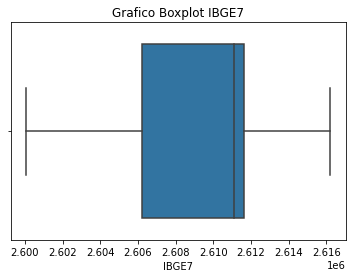

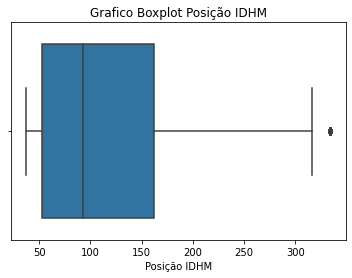

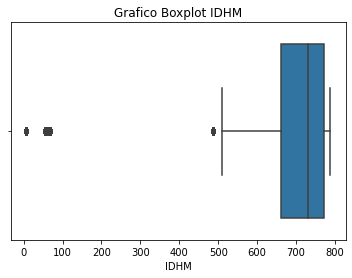

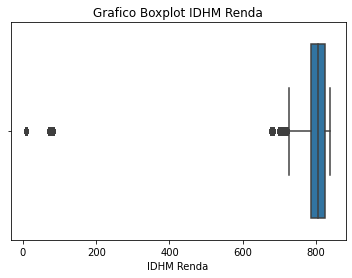

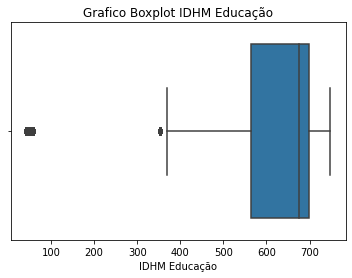

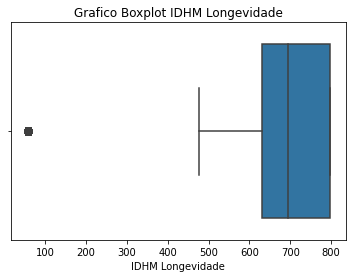

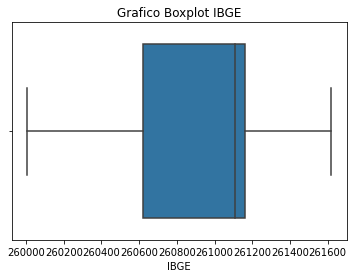

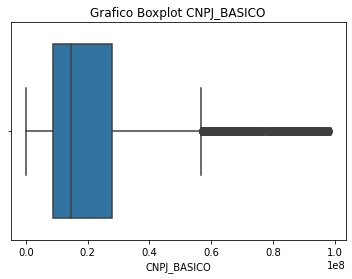

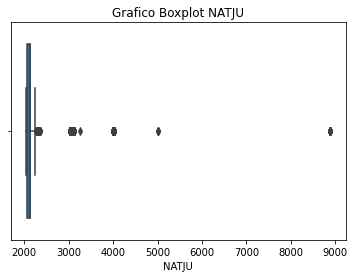

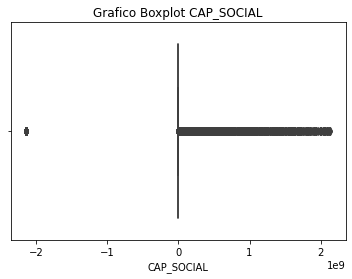

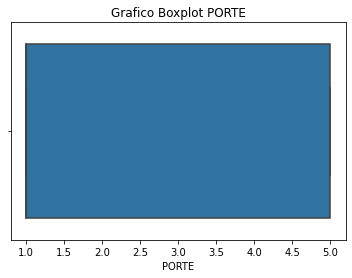

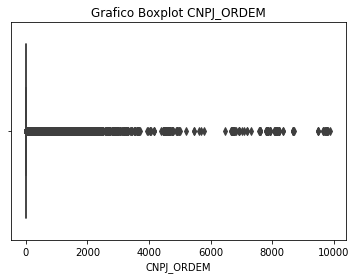

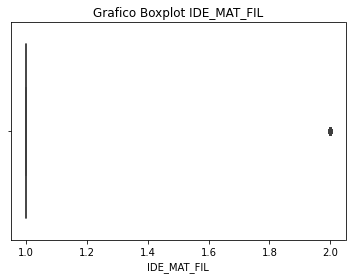

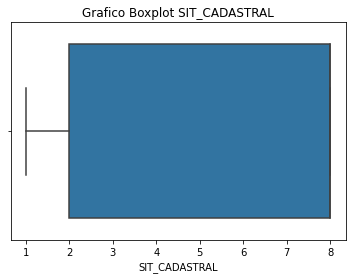

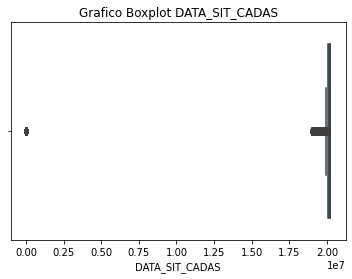

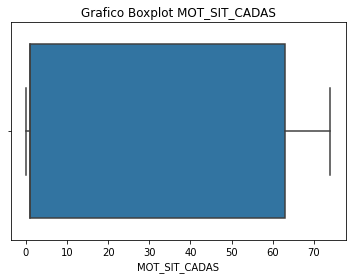

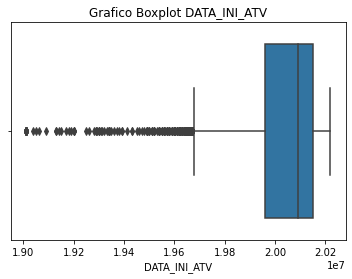

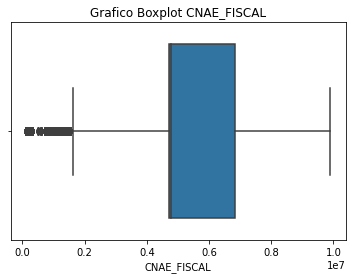

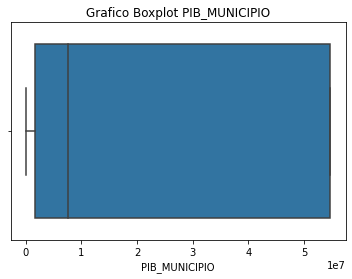

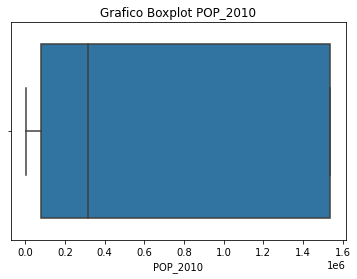

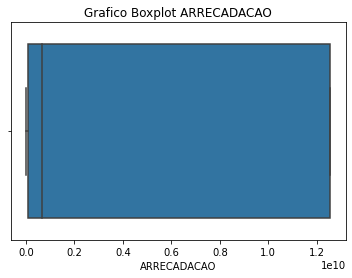

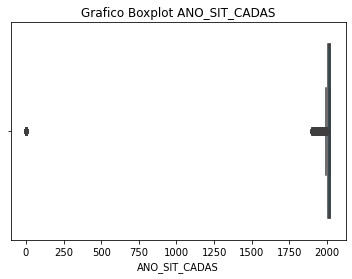

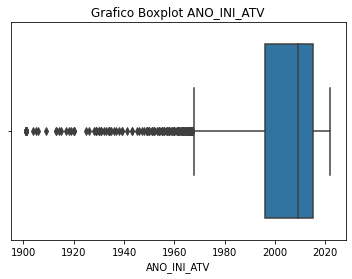

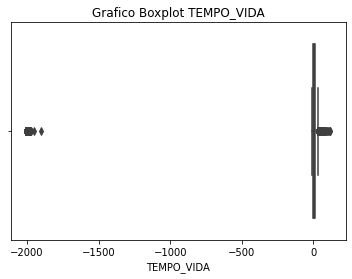

In [ ]:
#Buscando outliers a partir de graficos
for col in empresaspe.columns:
    plt.subplots()
    sns.boxplot(empresaspe[col])
    plt.title('Grafico Boxplot {}'.format(col));

In [ ]:
#IMPORTAR TABELA PIB
pib = pd.read_csv('/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL/Pib_anual2.csv', sep=";", encoding='UTF-8')

In [ ]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61250 entries, 0 to 61249
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ANO_PIB           61250 non-null  int64 
 1   UF                61250 non-null  object
 2   IBGE7             61250 non-null  int64 
 3   PIB_ANO           61250 non-null  int64 
 4   PIB_PERCAPTA_ANO  61250 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.3+ MB


In [ ]:
pib['PIB_PERCAPTA_ANO'] = pib['PIB_PERCAPTA_ANO'].str.replace(',', '').astype(float)

In [ ]:
#SEPARAR PIB MUNICIPIOS DE PE
PibPE = pib[pib['UF'] =='PE']

In [ ]:
PibPE['ANO_PIB'].value_counts()

2009    185
2010    185
2011    185
2012    185
2013    185
2014    185
2015    185
2016    185
2017    185
2018    185
2019    185
Name: ANO_PIB, dtype: int64

In [ ]:
PibPE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 1464 to 57329
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ANO_PIB           2035 non-null   int64  
 1   UF                2035 non-null   object 
 2   IBGE7             2035 non-null   int64  
 3   PIB_ANO           2035 non-null   int64  
 4   PIB_PERCAPTA_ANO  2035 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 95.4+ KB


In [ ]:
PibPE = PibPE.rename(columns={'ANO_PIB':'ANO_INI_ATV', 'PIB_ANO':'PIB_ANO_INIC', 'PIB_PERCAPTA_ANO':'PIB_PERCAPTA_INIC'})
PibPE.head()
PibPE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 1464 to 57329
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ANO_INI_ATV        2035 non-null   int64  
 1   UF                 2035 non-null   object 
 2   IBGE7              2035 non-null   int64  
 3   PIB_ANO_INIC       2035 non-null   int64  
 4   PIB_PERCAPTA_INIC  2035 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 95.4+ KB


In [ ]:
testePib = empresaspe
testePib = pd.merge(testePib,PibPE, on=['IBGE7','ANO_INI_ATV'], how='left')

In [ ]:
testePib.head()

,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,IBGE,CNPJ_BASICO,NATJU,CAP_SOCIAL,PORTE,CNPJ_ORDEM,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_MUNICIPIO,POP_2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA,UF,PIB_ANO_INIC,PIB_PERCAPTA_INIC
0,2600054,146,679,791,632,625,260005,45298913,2135,10000,1,1.000,1,2,20220215,0,20220215,4530705,1775521.662,94429,134509358.510,2022,2022,0,NaN,NaN,NaN
1,2600054,146,679,791,632,625,260005,69920775,2135,0,1,1.000,1,2,20051103,0,19930218,4530705,1775521.662,94429,134509358.510,2005,1993,12,NaN,NaN,NaN
2,2600054,146,679,791,632,625,260005,4393610,2135,0,1,1.000,1,8,20180717,1,20010416,4530705,1775521.662,94429,134509358.510,2018,2001,17,NaN,NaN,NaN
3,2600054,146,679,791,632,625,260005,7440052,2135,0,5,1.000,1,8,20150209,73,20050616,4530705,1775521.662,94429,134509358.510,2015,2005,10,NaN,NaN,NaN
4,2600054,146,679,791,632,625,260005,35459387,2135,20000,5,1.000,1,4,20190116,63,19901017,4530705,1775521.662,94429,134509358.510,2019,1990,29,NaN,NaN,NaN


In [ ]:
PibPE = PibPE.rename(columns={'ANO_INI_ATV':'ANO_SIT_CADAS', 'PIB_ANO_INIC':'PIB_ANO_SITCAD', 'PIB_PERCAPTA_INIC':'PIB_PERCAPTA_SITCAD'})
PibPE.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 1464 to 57329
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ANO_SIT_CADAS        2035 non-null   int64  
 1   UF                   2035 non-null   object 
 2   IBGE7                2035 non-null   int64  
 3   PIB_ANO_SITCAD       2035 non-null   int64  
 4   PIB_PERCAPTA_SITCAD  2035 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 95.4+ KB


In [ ]:
testePib = pd.merge(testePib,PibPE, on=['IBGE7','ANO_SIT_CADAS'], how='left')

In [ ]:
testePib.head()


,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,IBGE,CNPJ_BASICO,NATJU,CAP_SOCIAL,PORTE,CNPJ_ORDEM,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_MUNICIPIO,POP_2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA,UF_x,PIB_ANO_INIC,PIB_PERCAPTA_INIC,UF_y,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
0,2600054,146,679,791,632,625,260005,45298913,2135,10000,1,1.000,1,2,20220215,0,20220215,4530705,1775521.662,94429,134509358.510,2022,2022,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2600054,146,679,791,632,625,260005,69920775,2135,0,1,1.000,1,2,20051103,0,19930218,4530705,1775521.662,94429,134509358.510,2005,1993,12,NaN,NaN,NaN,NaN,NaN,NaN
2,2600054,146,679,791,632,625,260005,4393610,2135,0,1,1.000,1,8,20180717,1,20010416,4530705,1775521.662,94429,134509358.510,2018,2001,17,NaN,NaN,NaN,PE,1725557.000,1732105.000
3,2600054,146,679,791,632,625,260005,7440052,2135,0,5,1.000,1,8,20150209,73,20050616,4530705,1775521.662,94429,134509358.510,2015,2005,10,NaN,NaN,NaN,PE,1333651.000,1352560.000
4,2600054,146,679,791,632,625,260005,35459387,2135,20000,5,1.000,1,4,20190116,63,19901017,4530705,1775521.662,94429,134509358.510,2019,1990,29,NaN,NaN,NaN,PE,1775522.000,1775699.000


Existem 804032 instâncias no conjunto de dados sem valores nulos, cujos atributos são numericos.\
Os campos CNPJ_BASICO, CNPJ_ORDEM serão excluidos do dataset, pois suas informações são irrelevantes dado tratar-se de parametros individuais de identificação da empresa.\
O campo IBGE possui dados similares ao IBGE7 servindo apenas para identificar UF/MUNICIPIO, portanto também será excluido.\ 
O campo CAPITAL SOCIAL possui 308997 registros zerados, 59098 com valor de 1 e registros com valores excessivamente discrepantes no capital social. Claramente trata-se de informação enviezada que pode causar discrepancias no modelo, e portanto será descartado.

In [ ]:
df = testePib.drop(columns=['CNPJ_BASICO','CNPJ_ORDEM','IBGE','CAP_SOCIAL'])
df.head()

,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,NATJU,PORTE,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_MUNICIPIO,POP_2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA,UF_x,PIB_ANO_INIC,PIB_PERCAPTA_INIC,UF_y,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
0,2600054,146,679,791,632,625,2135,1,1,2,20220215,0,20220215,4530705,1775521.662,94429,134509358.510,2022,2022,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2600054,146,679,791,632,625,2135,1,1,2,20051103,0,19930218,4530705,1775521.662,94429,134509358.510,2005,1993,12,NaN,NaN,NaN,NaN,NaN,NaN
2,2600054,146,679,791,632,625,2135,1,1,8,20180717,1,20010416,4530705,1775521.662,94429,134509358.510,2018,2001,17,NaN,NaN,NaN,PE,1725557.000,1732105.000
3,2600054,146,679,791,632,625,2135,5,1,8,20150209,73,20050616,4530705,1775521.662,94429,134509358.510,2015,2005,10,NaN,NaN,NaN,PE,1333651.000,1352560.000
4,2600054,146,679,791,632,625,2135,5,1,4,20190116,63,19901017,4530705,1775521.662,94429,134509358.510,2019,1990,29,NaN,NaN,NaN,PE,1775522.000,1775699.000


In [ ]:
# exame de quantas são as categorias de 'SIT_CADASTRAL'
df['SIT_CADASTRAL'].value_counts()

8    460929
2    200852
4    136537
3      4200
1      1514
Name: SIT_CADASTRAL, dtype: int64

In [ ]:
df['ANO_INI_ATV'].head()

0    2022
1    1993
2    2001
3    2005
4    1990
Name: ANO_INI_ATV, dtype: int64

In [ ]:
#TRABALAR APENAS COM PORTE DE MICRO E PEQUENA EMPRESA
df = df[df['PORTE'] == 1]

In [ ]:
#SEPARAR EMPRESAS COMO INICIO DE ATIVIDADE EM 2009
df_2009 = df[df['ANO_INI_ATV'] >= 2009]

In [ ]:
#SEPARAR EMPRESAS COMO SITUAÇÃO CADASTRAL DE
df_09_19 = df_2009[df_2009['ANO_SIT_CADAS'] <= 2019]

In [ ]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349808 entries, 0 to 803931
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                349808 non-null  int64  
 1   Posição IDHM         349808 non-null  int64  
 2   IDHM                 349808 non-null  int64  
 3   IDHM Renda           349808 non-null  int64  
 4   IDHM Educação        349808 non-null  int64  
 5   IDHM Longevidade     349808 non-null  int64  
 6   NATJU                349808 non-null  int64  
 7   PORTE                349808 non-null  int64  
 8   IDE_MAT_FIL          349808 non-null  int64  
 9   SIT_CADASTRAL        349808 non-null  int64  
 10  DATA_SIT_CADAS       349808 non-null  int64  
 11  MOT_SIT_CADAS        349808 non-null  int64  
 12  DATA_INI_ATV         349808 non-null  int64  
 13  CNAE_FISCAL          349808 non-null  int64  
 14  PIB_MUNICIPIO        349808 non-null  float64
 15  POP_2010         

In [ ]:
df_2009['ANO_INI_ATV'].value_counts()

2013    33032
2014    31428
2011    29739
2010    29457
2012    29279
2015    27229
2018    27002
2019    26851
2017    26807
2016    24141
2020    23836
2021    23629
2009    14167
2022     3211
Name: ANO_INI_ATV, dtype: int64

In [ ]:
# resumo dos atributos numéricos
df_2009.describe()

,IBGE7,Posição IDHM,IDHM,IDHM Renda,IDHM Educação,IDHM Longevidade,NATJU,PORTE,IDE_MAT_FIL,SIT_CADASTRAL,DATA_SIT_CADAS,MOT_SIT_CADAS,DATA_INI_ATV,CNAE_FISCAL,PIB_MUNICIPIO,POP_2010,ARRECADACAO,ANO_SIT_CADAS,ANO_INI_ATV,TEMPO_VIDA,PIB_ANO_INIC,PIB_PERCAPTA_INIC,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
count,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,349808.000,299132.000,299132.000,236219.000,236219.000
mean,2609000.498,123.460,684.160,741.941,602.083,683.034,2131.328,1.000,1.035,5.908,20180414.463,16.009,20151032.648,5483694.388,21578884.929,646055.475,4633039031.203,2017.983,2015.037,2.946,17552607.013,2016886.670,19745392.266,2325988.142
std,3809.232,65.975,128.212,206.552,131.883,130.927,50.075,0.000,0.184,2.673,28236.514,27.279,36071.513,2018147.426,24299525.044,658590.064,5813037951.464,2.828,3.609,3.177,20964359.435,1479617.560,22766053.355,1789068.146
min,2600054.000,37.000,6.000,8.000,42.000,53.000,2054.000,1.000,1.000,1.000,20070620.000,0.000,20090105.000,111302.000,37869.808,2630.000,837467.860,2007.000,2009.000,-3.000,21277.000,293253.000,21277.000,293253.000
25%,2606002.000,53.000,652.000,782.000,564.000,625.000,2135.000,1.000,1.000,2.000,20170208.000,0.000,20120615.000,4712100.000,1591320.358,77302.000,94523939.190,2017.000,2012.000,0.000,1023282.000,1106845.000,1336854.000,1273140.000
50%,2610905.000,128.000,697.000,805.000,628.000,681.000,2135.000,1.000,1.000,8.000,20181025.000,1.000,20150413.000,4781400.000,7266146.277,300466.000,645825330.450,2018.000,2015.000,2.000,5271214.000,1600801.000,5774907.000,1829544.000
75%,2611606.000,164.000,772.000,825.000,698.000,798.000,2135.000,1.000,1.000,8.000,20201027.000,1.000,20180816.000,6821801.000,54691223.455,1537704.000,12556942916.660,2020.000,2018.000,5.000,42890606.000,2924089.000,49405397.000,3173130.000
max,2616209.000,334.000,788.000,839.000,748.000,798.000,2321.000,1.000,2.000,8.000,20220312.000,74.000,20220312.000,9700500.000,54691223.455,1537704.000,12556942916.660,2022.000,2022.000,13.000,54691223.000,13220617.000,54691223.000,13220617.000


As linhas de contagem (**count**), média (**mean**), mínimo (**min**) e máximo (**max**) são autoexplicativas.

Valores nulos são ignorados.

A linha **std** mostra o desvio padrão, que mede a dispersão dos valores daquela coluna.

As linhas **25%**, **50%** e **75%** mostram os percentis correspondentes. 

Analise:

25%
Posição IDHM = 53
IDMH = 661
IDHM Renda=
IDHM Educação
IDHM Longevidade
SIT_CADASTRAL

In [ ]:
df_09_19 = df_2009[df_2009['ANO_SIT_CADAS'] <= 2019]

In [ ]:
df_09_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236220 entries, 40 to 803931
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  int64  
 1   Posição IDHM         236220 non-null  int64  
 2   IDHM                 236220 non-null  int64  
 3   IDHM Renda           236220 non-null  int64  
 4   IDHM Educação        236220 non-null  int64  
 5   IDHM Longevidade     236220 non-null  int64  
 6   NATJU                236220 non-null  int64  
 7   PORTE                236220 non-null  int64  
 8   IDE_MAT_FIL          236220 non-null  int64  
 9   SIT_CADASTRAL        236220 non-null  int64  
 10  DATA_SIT_CADAS       236220 non-null  int64  
 11  MOT_SIT_CADAS        236220 non-null  int64  
 12  DATA_INI_ATV         236220 non-null  int64  
 13  CNAE_FISCAL          236220 non-null  int64  
 14  PIB_MUNICIPIO        236220 non-null  float64
 15  POP_2010        

#DEFININDO AS VARIAVEIS PARA O MODELO
IBGE7\
IDHM\
NATJU\
PORTE\
SIT_CADASTRAL\
CNAE_FISCAL\
PIB_MUNICIPIO\
POP_2010\
ARRECADACAO\
TEMPO_VIDA\

In [ ]:
selec  = ['IBGE7','IDHM','NATJU','SIT_CADASTRAL','CNAE_FISCAL','ARRECADACAO','TEMPO_VIDA','PIB_ANO_INIC','PIB_PERCAPTA_INIC','PIB_ANO_SITCAD','PIB_PERCAPTA_SITCAD']
df_modelo = df_09_19.filter(items=selec)
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236220 entries, 40 to 803931
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  int64  
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  int64  
 3   SIT_CADASTRAL        236220 non-null  int64  
 4   CNAE_FISCAL          236220 non-null  int64  
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 21.6 MB


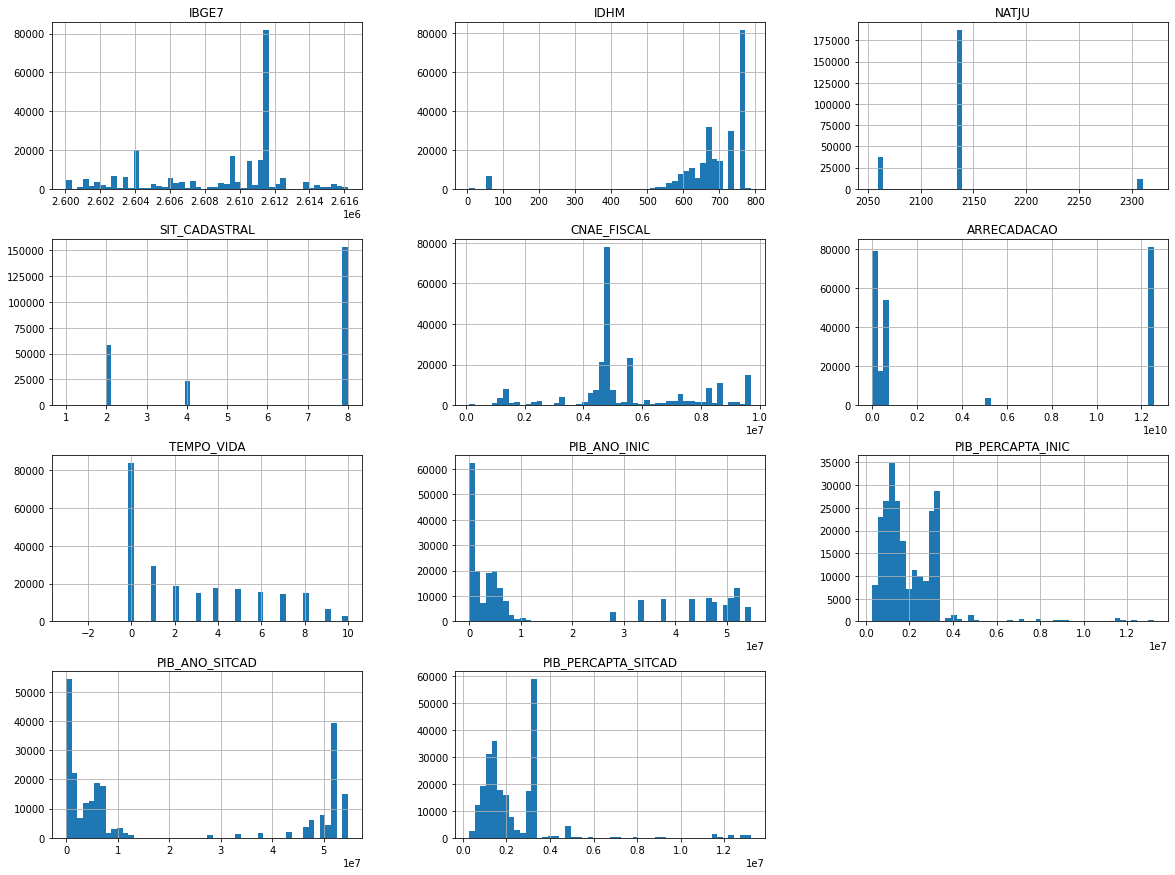

In [ ]:
# podemos mostrar os histogramas para observar a distribuição de todos os valores
df_modelo.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236220 entries, 40 to 803931
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  int64  
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  int64  
 3   SIT_CADASTRAL        236220 non-null  int64  
 4   CNAE_FISCAL          236220 non-null  int64  
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 21.6 MB


In [ ]:
#EXPORTAR DATASET TRATADO PARA APLICAR MODELO
df_modelo.to_csv(r'/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL/df_modelo.csv', index = False)

In [ ]:
df_modelo.tail(10)

,IBGE7,IDHM,NATJU,SIT_CADASTRAL,CNAE_FISCAL,ARRECADACAO,TEMPO_VIDA,PIB_ANO_INIC,PIB_PERCAPTA_INIC,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
803897,2616209,582,2062,2,1340502,9030756.470,0,161396.000,807950.000,161396.000,807950.000
803898,2616209,582,2062,2,1340502,9030756.470,0,171586.000,827680.000,171586.000,827680.000
803899,2616209,582,2062,2,1033301,9030756.470,0,161396.000,807950.000,161396.000,807950.000
803907,2616209,582,2305,2,1412601,9030756.470,0,64551.000,354950.000,64551.000,354950.000
803913,2616209,582,2305,2,4781400,9030756.470,0,153694.000,751192.000,153694.000,751192.000
803916,2616209,582,2305,2,4755502,9030756.470,0,64551.000,354950.000,64551.000,354950.000
803917,2616209,582,2305,2,4755502,9030756.470,0,140663.000,713301.000,140663.000,713301.000
803920,2616209,582,2305,2,4731800,9030756.470,0,161396.000,807950.000,161396.000,807950.000
803922,2616209,582,2305,2,4618499,9030756.470,0,171586.000,827680.000,171586.000,827680.000
803931,2616209,582,2305,2,9601702,9030756.470,0,112239.000,599695.000,112239.000,599695.000


In [ ]:
corr_matriz = df_modelo.corr()

In [ ]:
corr_matriz['SIT_CADASTRAL'].sort_values(ascending=False)

SIT_CADASTRAL          1.000
TEMPO_VIDA             0.294
IDHM                   0.029
PIB_PERCAPTA_SITCAD    0.016
CNAE_FISCAL            0.006
PIB_ANO_SITCAD         0.006
IBGE7                 -0.009
NATJU                 -0.011
ARRECADACAO           -0.013
PIB_ANO_INIC          -0.021
PIB_PERCAPTA_INIC     -0.038
Name: SIT_CADASTRAL, dtype: float64

In [ ]:
corr_matriz['TEMPO_VIDA'].sort_values(ascending=False)

TEMPO_VIDA             1.000
SIT_CADASTRAL          0.294
PIB_PERCAPTA_SITCAD    0.083
PIB_ANO_SITCAD         0.040
IDHM                   0.015
ARRECADACAO            0.012
IBGE7                  0.000
CNAE_FISCAL           -0.061
NATJU                 -0.081
PIB_ANO_INIC          -0.084
PIB_PERCAPTA_INIC     -0.162
Name: TEMPO_VIDA, dtype: float64

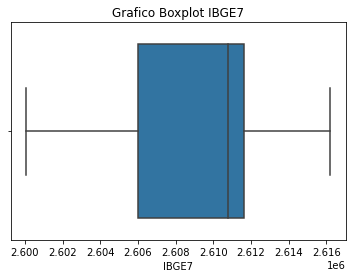

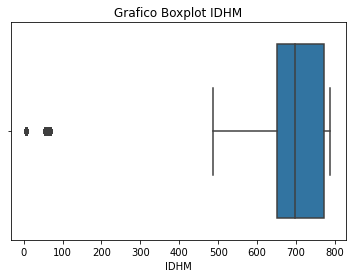

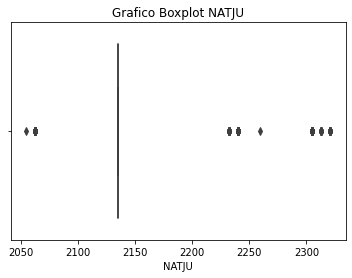

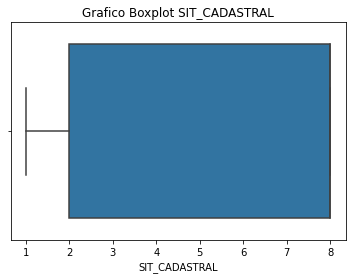

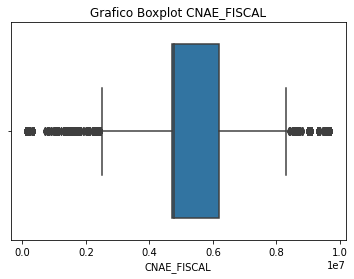

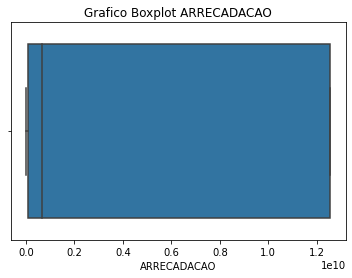

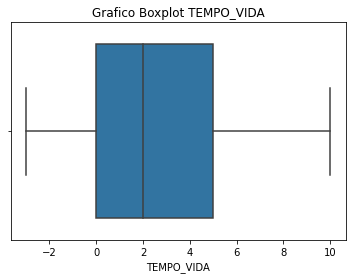

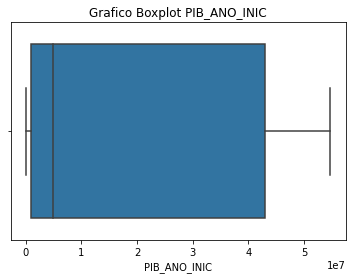

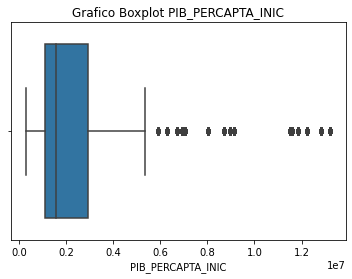

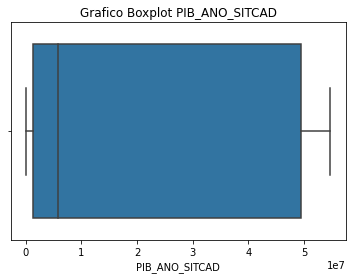

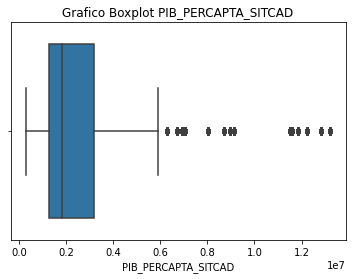

In [ ]:
#Buscando outliers a partir de graficos
for col in df_modelo.columns:
    plt.subplots()
    sns.boxplot(df_modelo[col])
    plt.title('Grafico Boxplot {}'.format(col));

In [ ]:
# Importação das Bibliotecas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import scipy
# cada linha representa uma empresa
import os
#os.chdir('D:\#PROJETOS\FURG\ECD-CIENCIA DE DADOS\#TCC-FURG\BASE-RFB-12-03-2022\TRATADA')
os.chdir("/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL")
df_modelo = pd.read_csv('df_modelo.csv', sep=",", encoding='UTF-8')

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  int64  
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  int64  
 3   SIT_CADASTRAL        236220 non-null  int64  
 4   CNAE_FISCAL          236220 non-null  int64  
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 19.8 MB


In [ ]:
df_modelo['IBGE7'] = df_modelo['IBGE7'].astype(str)

In [ ]:
df_modelo.head()

,IBGE7,IDHM,NATJU,SIT_CADASTRAL,CNAE_FISCAL,ARRECADACAO,TEMPO_VIDA,PIB_ANO_INIC,PIB_PERCAPTA_INIC,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
0,2600054,679,2135,8,5611201,134509358.510,4,740917.000,769656.000,1220149.000,1247775.000
1,2600054,679,2135,8,5611201,134509358.510,3,740917.000,769656.000,1113557.000,1169174.000
2,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
3,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
4,2600054,679,2135,8,5611201,134509358.510,2,853291.000,903642.000,1113557.000,1169174.000


In [ ]:
df_modelo['NATJU'] = df_modelo['NATJU'].astype(str)

In [ ]:
df_modelo['SIT_CADASTRAL'] = df_modelo['SIT_CADASTRAL'].astype(str)

In [ ]:
df_modelo['CNAE_FISCAL'] = df_modelo['CNAE_FISCAL'].astype(str)

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  object 
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  object 
 3   SIT_CADASTRAL        236220 non-null  object 
 4   CNAE_FISCAL          236220 non-null  object 
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 19.8+ MB


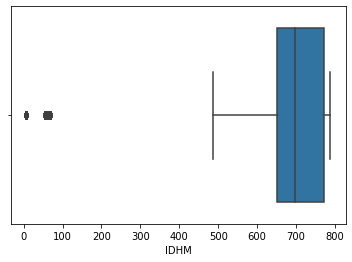

In [ ]:
import seaborn as sns
#Buscando outliers a partir de graficos
plt.subplots()
sns.boxplot(df_modelo['IDHM'])

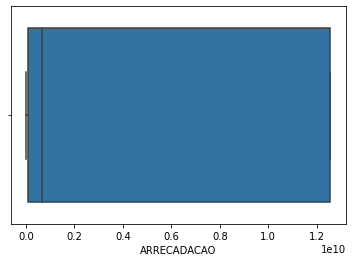

In [ ]:
sns.boxplot(df_modelo['ARRECADACAO'])

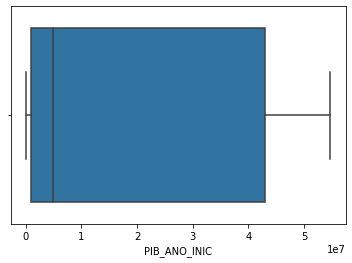

In [ ]:
sns.boxplot(df_modelo['PIB_ANO_INIC'])

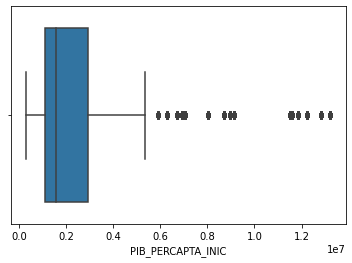

In [ ]:
sns.boxplot(df_modelo['PIB_PERCAPTA_INIC'])

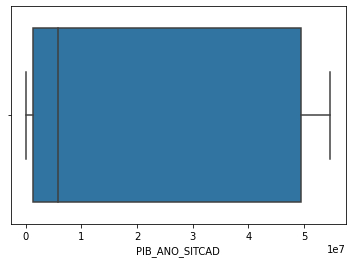

In [ ]:
sns.boxplot(df_modelo['PIB_ANO_SITCAD'])

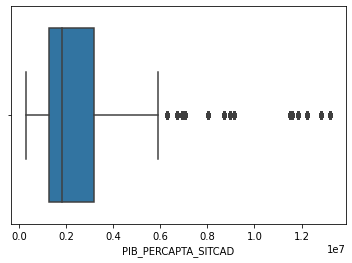

In [ ]:
sns.boxplot(df_modelo['PIB_PERCAPTA_SITCAD'])

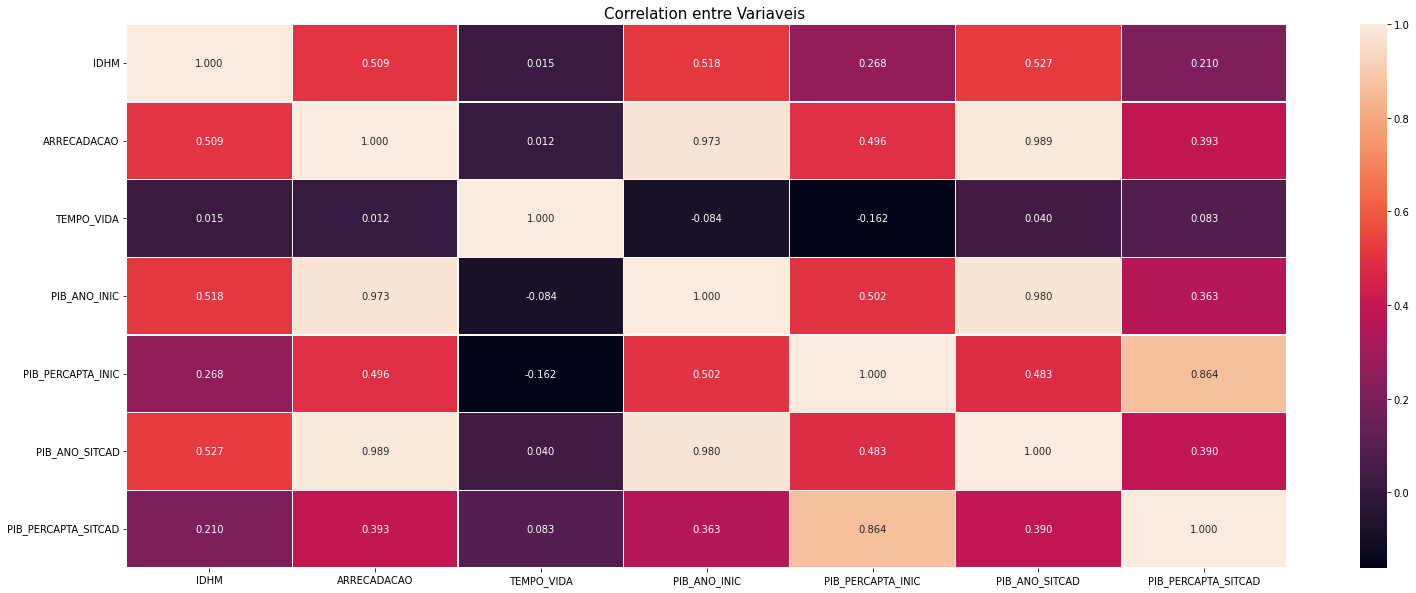

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(26, 10))
sns.heatmap(df_modelo.corr(), annot=True, linewidths=.22, fmt= '.3f',ax=ax)
plt.title('Correlation entre Variaveis ', fontsize=15);
plt.show()

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  object 
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  object 
 3   SIT_CADASTRAL        236220 non-null  object 
 4   CNAE_FISCAL          236220 non-null  object 
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 19.8+ MB


In [ ]:
df_modelo.head(50)

,IBGE7,IDHM,NATJU,SIT_CADASTRAL,CNAE_FISCAL,ARRECADACAO,TEMPO_VIDA,PIB_ANO_INIC,PIB_PERCAPTA_INIC,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
0,2600054,679,2135,8,5611201,134509358.510,4,740917.000,769656.000,1220149.000,1247775.000
1,2600054,679,2135,8,5611201,134509358.510,3,740917.000,769656.000,1113557.000,1169174.000
2,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
3,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
4,2600054,679,2135,8,5611201,134509358.510,2,853291.000,903642.000,1113557.000,1169174.000
5,2600054,679,2135,8,5611201,134509358.510,8,853291.000,903642.000,1725557.000,1732105.000
6,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
7,2600054,679,2135,8,5611201,134509358.510,8,853291.000,903642.000,1725557.000,1732105.000
8,2600054,679,2135,8,5611201,134509358.510,6,853291.000,903642.000,1416084.000,1430532.000
9,2600054,679,2135,8,5611201,134509358.510,7,946179.000,997627.000,1725557.000,1732105.000


In [ ]:
df_modelo.min()

IBGE7                    2600054
IDHM                           6
NATJU                       2054
SIT_CADASTRAL                  1
CNAE_FISCAL              1011201
ARRECADACAO           837467.860
TEMPO_VIDA                    -3
PIB_ANO_INIC           21277.000
PIB_PERCAPTA_INIC     293253.000
PIB_ANO_SITCAD         21277.000
PIB_PERCAPTA_SITCAD   293253.000
dtype: object

In [ ]:
#Buscando a origem dos valores negativos
df_modelo[df_modelo['TEMPO_VIDA'] < 0]['IBGE7'].value_counts()

2611606    1
Name: IBGE7, dtype: int64

In [ ]:
df_modelo['CNAE_FISCAL'].value_counts(normalize=True).head()

4781400   0.084
4712100   0.033
9602501   0.029
5611203   0.027
5611201   0.026
Name: CNAE_FISCAL, dtype: float64

In [ ]:
selec = ['4781400',
'4712100',
'9602501',
'5611203',
'5611201',
'4772500',
'4723700',
'1412601',
'4744099',
'5620104',
'7319002',
'4729699',
'4530703',
'5612100',
'9511800',
'8230001',
'4789099',
'4399103',
'5611204',
'4751201',
'4771701',
'4321500',
'4755502',
'6920601',
'4930202',
'8599604',
'8211300',
'9602502',
'1091102',
'4754701',
'4724500',
'4789004',
'8599699',
'4782201']

In [ ]:
selec

['4781400',
 '4712100',
 '9602501',
 '5611203',
 '5611201',
 '4772500',
 '4723700',
 '1412601',
 '4744099',
 '5620104',
 '7319002',
 '4729699',
 '4530703',
 '5612100',
 '9511800',
 '8230001',
 '4789099',
 '4399103',
 '5611204',
 '4751201',
 '4771701',
 '4321500',
 '4755502',
 '6920601',
 '4930202',
 '8599604',
 '8211300',
 '9602502',
 '1091102',
 '4754701',
 '4724500',
 '4789004',
 '8599699',
 '4782201']

In [ ]:
def listaPE(dataframe, valores):
    return dataframe.loc[dataframe['CNAE_FISCAL'].isin(valores)]
lista = ['4781400',
'4712100',
'9602501',
'5611203',
'5611201',
'4772500',
'4723700',
'1412601',
'4744099',
'5620104',
'7319002',
'4729699',
'4530703',
'5612100',
'9511800',
'8230001',
'4789099',
'4399103',
'5611204',
'4751201',
'4771701',
'4321500',
'4755502',
'6920601',
'4930202',
'8599604',
'8211300',
'9602502',
'1091102',
'4754701',
'4724500',
'4789004',
'8599699',
'4782201']
df_final = listaPE(df_modelo, lista)

In [ ]:
df_final = df_modelo

In [ ]:
df_final.head()

,IBGE7,IDHM,NATJU,SIT_CADASTRAL,CNAE_FISCAL,ARRECADACAO,TEMPO_VIDA,PIB_ANO_INIC,PIB_PERCAPTA_INIC,PIB_ANO_SITCAD,PIB_PERCAPTA_SITCAD
0,2600054,679,2135,8,5611201,134509358.510,4,740917.000,769656.000,1220149.000,1247775.000
1,2600054,679,2135,8,5611201,134509358.510,3,740917.000,769656.000,1113557.000,1169174.000
2,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
3,2600054,679,2135,4,5611201,134509358.510,9,853291.000,903642.000,1775522.000,1775699.000
4,2600054,679,2135,8,5611201,134509358.510,2,853291.000,903642.000,1113557.000,1169174.000


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  object 
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  object 
 3   SIT_CADASTRAL        236220 non-null  object 
 4   CNAE_FISCAL          236220 non-null  object 
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 19.8+ MB


In [ ]:
df_final['CNAE_FISCAL'].value_counts(normalize=True)

4781400   0.084
4712100   0.033
9602501   0.029
5611203   0.027
5611201   0.026
4772500   0.020
4723700   0.019
1412601   0.018
4744099   0.016
5620104   0.013
7319002   0.013
4729699   0.012
4530703   0.012
5612100   0.012
9511800   0.012
8230001   0.011
4789099   0.010
4399103   0.010
5611204   0.010
4751201   0.010
4771701   0.010
4321500   0.010
4755502   0.009
6920601   0.009
4930202   0.008
8599604   0.008
8211300   0.008
9602502   0.008
1091102   0.008
4754701   0.008
4724500   0.008
4789004   0.008
8599699   0.007
4782201   0.007
4774100   0.007
7319003   0.007
4923001   0.007
4930201   0.007
5320202   0.006
4120400   0.006
4520001   0.006
4541206   0.006
4784900   0.006
4752100   0.006
9313100   0.006
4789001   0.006
4721102   0.005
4721103   0.005
4754702   0.005
4722901   0.005
1412602   0.005
1412603   0.005
4755503   0.005
3101200   0.005
4520005   0.005
7911200   0.005
3299099   0.005
8219999   0.005
4721104   0.004
8630504   0.004
9001902   0.004
4330404   0.004
8630503 

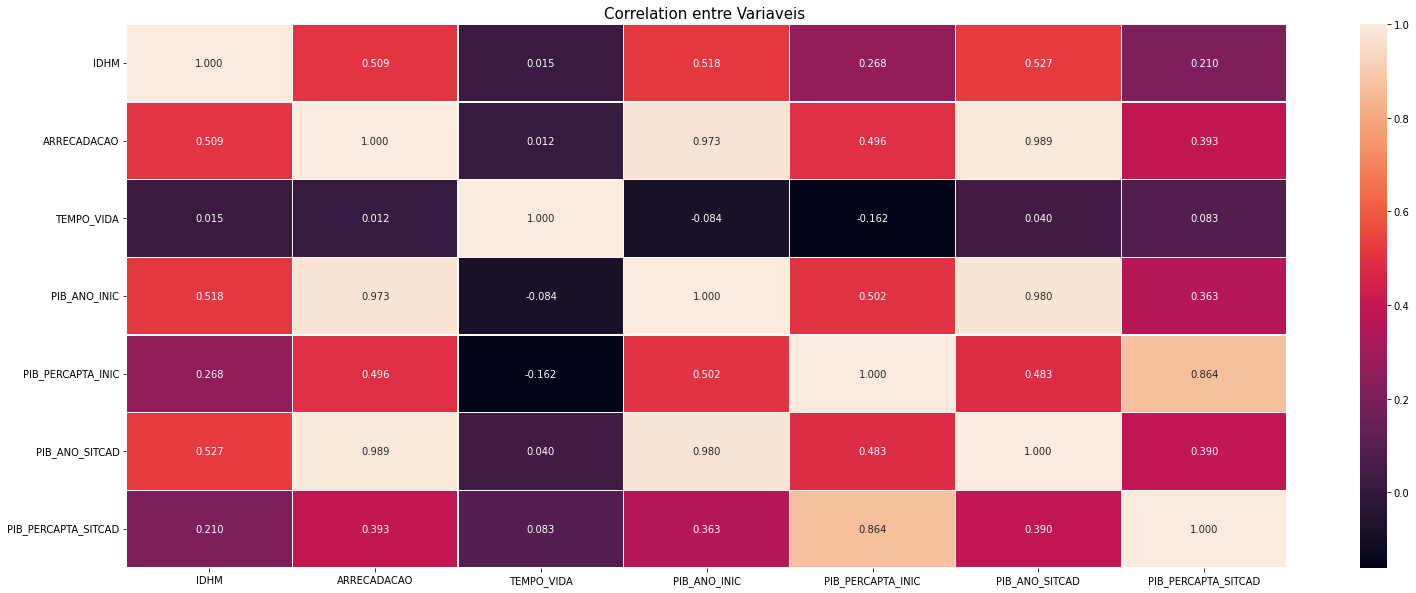

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(26, 10))
sns.heatmap(df_final.corr(), annot=True, linewidths=.22, fmt= '.3f',ax=ax)
plt.title('Correlation entre Variaveis ', fontsize=15);
plt.show()

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  object 
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  object 
 3   SIT_CADASTRAL        236220 non-null  object 
 4   CNAE_FISCAL          236220 non-null  object 
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 19.8+ MB


In [ ]:
#EXPORTAR DATASET TRATADO PARA APLICAR MODELO
df_final.to_csv(r'/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL/df_final2.csv', index = False)

In [ ]:
import os
df_final2 = pd.read_csv('/content/drive/MyDrive/FURG-TCC/TCC - DADOS E ANALISE/DADOS/FINAL/df_final2.csv', sep=",", encoding='UTF-8')

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  object 
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  object 
 3   SIT_CADASTRAL        236220 non-null  object 
 4   CNAE_FISCAL          236220 non-null  object 
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 19.8+ MB


In [ ]:
df_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236220 entries, 0 to 236219
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   IBGE7                236220 non-null  int64  
 1   IDHM                 236220 non-null  int64  
 2   NATJU                236220 non-null  int64  
 3   SIT_CADASTRAL        236220 non-null  int64  
 4   CNAE_FISCAL          236220 non-null  int64  
 5   ARRECADACAO          236220 non-null  float64
 6   TEMPO_VIDA           236220 non-null  int64  
 7   PIB_ANO_INIC         236220 non-null  float64
 8   PIB_PERCAPTA_INIC    236220 non-null  float64
 9   PIB_ANO_SITCAD       236219 non-null  float64
 10  PIB_PERCAPTA_SITCAD  236219 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 19.8 MB
